# Fisheye Cubemap

From perspective projections in a cubemap, generate a fisheye image

In [1]:
from Source.geometry import *
from Source.camera import *
import cv2
import glob
from scipy.interpolate import griddata

# Helper functions for visualization.
%matplotlib inline
from IPython.display import HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Field of view (FoV) in radians
fov = (np.pi/180.)*170.
#fov = np.pi
fov = 2.*np.pi

# Size of images
imsize_x = 1280
imsize_y = 1280
imagesize = imsize_x

# Output figure scale, use larger value to get lower figure size
figscale = 1
# DPI
my_dpi = 96
# Path where cubemap images are stored
image_path = "../Imagesets/ProjectionsFoV180"
image_path = "../Imagesets/ProjectionsFoV360"
# Resize factor (use low values for faster tests)
scale_percent = 1/2
# Window size for rectangle view (not implemented well yet)
window_x = 0.6
window_y = 0.4


# Utility function to reflect an image
def reflect_image(img, flip):
    
    rows, cols = img.shape[:2]
    if flip=="h":
        M = np.float32([[1, 0, 0], [0, -1, rows],[0,  0, 1]])
    elif flip=="v":
        M = np.float32([[-1, 0, cols], [0, 1, 0], [0, 0, 1]])
    reflected_img = cv2.warpPerspective(img, M, (int(cols), int(rows)))
    
    return reflected_img

# 3D plot routine
def threedplot2(x0, scale=1, cols = None, s=10):
    
    w = 10
    fig = plt.figure(figsize=(w*scale,w))
    ax1 = fig.add_subplot(1,2,1, projection ="3d")
    if cols is None: cols = "orange"
    ax1.scatter(x0[:, 0], x0[:, 1], x0[:, 2], c=cols, edgecolors=None,s=s)
    #ax1.view_init(elev=90., azim=90)
    ax1.view_init(elev=30., azim=30)

# Render an image as scatter plot of points (computationally cheaper than grid)
def projected_image_points(x, y, title, cols, f=1):

    figsize_x, figsize_y = imsize_x/my_dpi/figscale, imsize_y/my_dpi/figscale
    fig = plt.figure(figsize=(figsize_x, figsize_y), dpi=my_dpi)
    fig.subplots_adjust(
        bottom=0.,
        left=0.
    )
    
    plt.scatter(x*f,y*f, s=1, c=cols)
    
    plt.axis('off')
    plt.tight_layout(pad=0.)
    plt.savefig("images/projections/"+title.replace(" projection","")+".png")
    plt.show()

# Render an image interpolating in a grid of pixels (computationally more expensive than points)
def projected_image_grid(xin, yin, title, vals, f=1, mask=None):
    
    figsize_x, figsize_y = imsize_x/my_dpi/figscale, imsize_y/my_dpi/figscale
    fig = plt.figure(figsize=(figsize_x, figsize_y), dpi=my_dpi)
    fig.subplots_adjust(
        bottom=0.,
        left=0.
    )
    
    x, y = f*xin, f*yin

    grid_x, grid_y = np.meshgrid(np.linspace(x.min(), x.max(), imsize_x), np.linspace(y.min(), y.max(), imsize_y))
    
    points = np.concatenate([x.reshape(-1,1), y.reshape(-1,1)], axis=1)
    grid = griddata(points, vals, (grid_x, grid_y), method='nearest')
    grid = np.rot90(np.transpose(grid,axes=(1,0,2)), k=1, axes=(0, 1))
    
    if mask is not None:
        grid[~mask] = 1.
        #grid[np.isnan(grid)] = 1.   # if other interpolation is used 
    
    plt.imshow(grid)
    
    plt.axis('off')
    plt.tight_layout(pad=0.)
    #plt.savefig("images/projections/"+title.replace(" projection","")+".png")
    plt.show()

# Create a circular mask
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

Equidistant projection
Unreal render


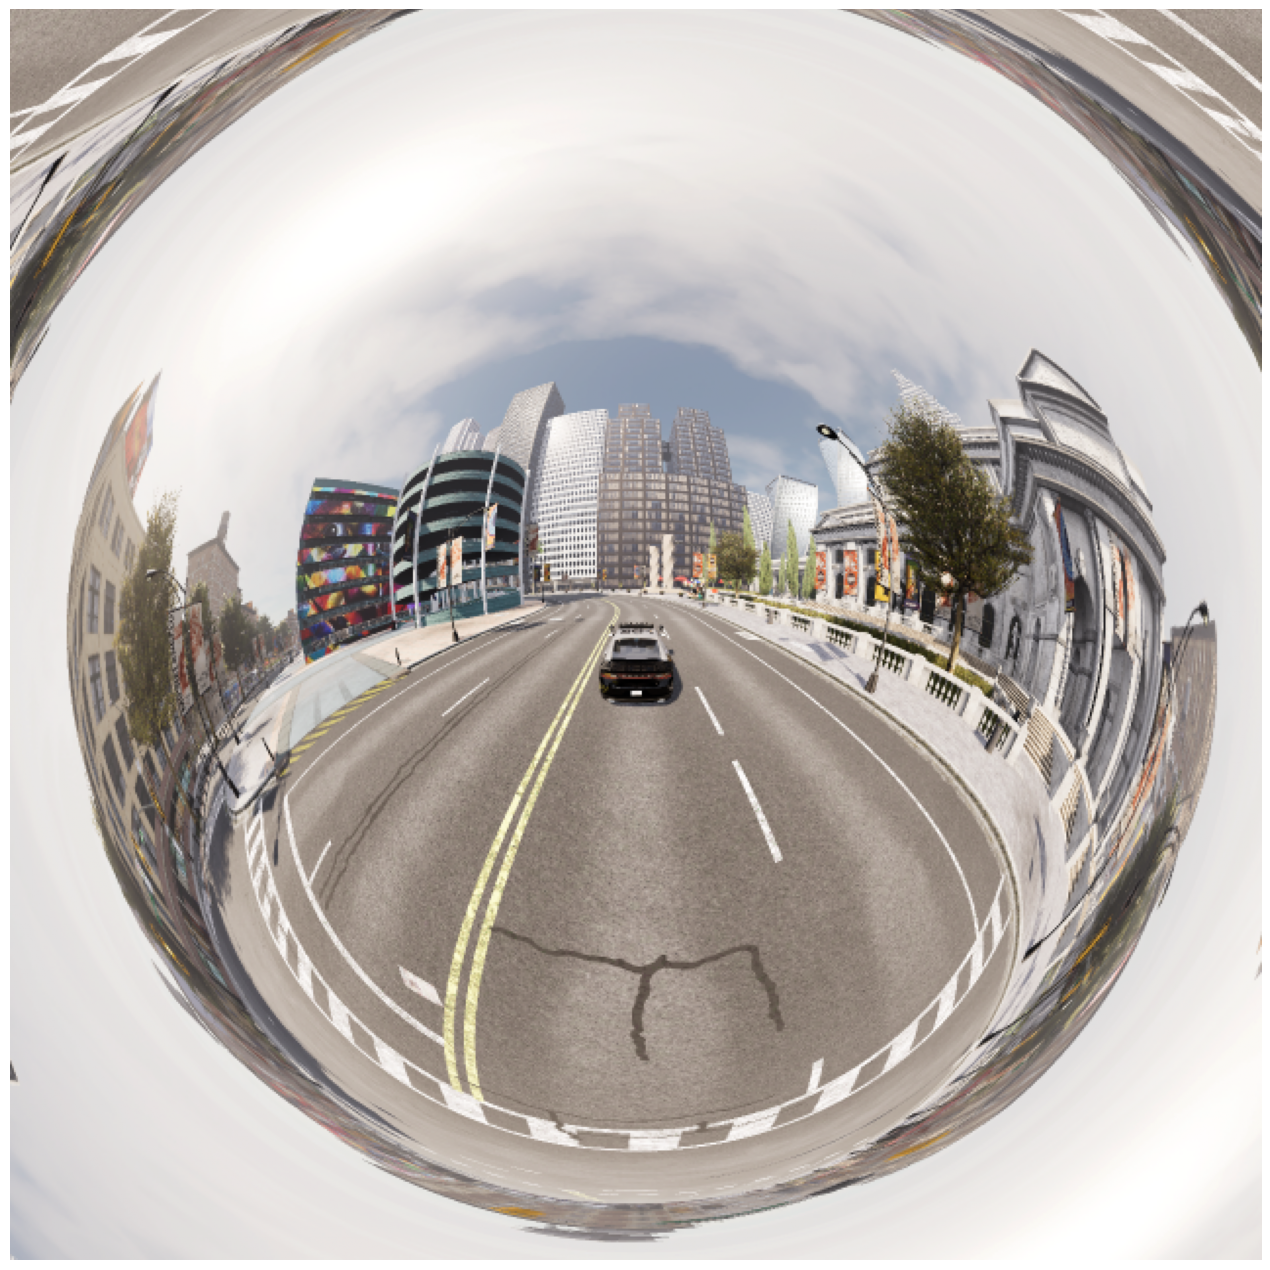

Python render


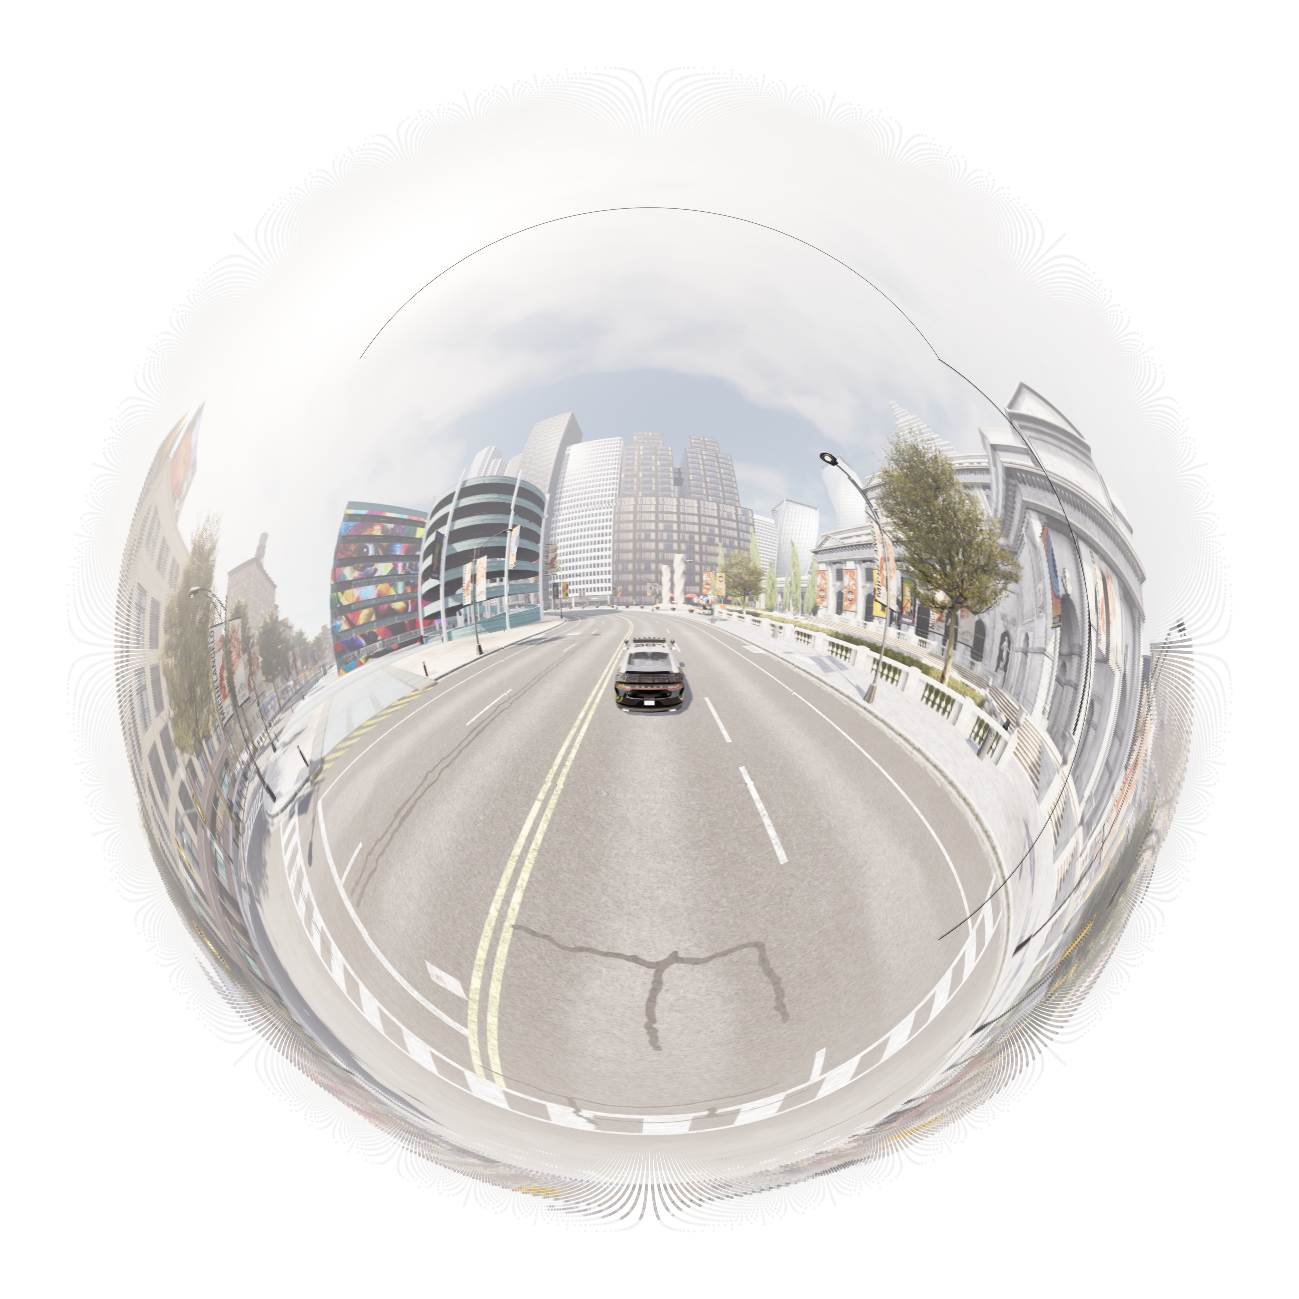

FoV to high for unwrapping


In [2]:
# Generate a cube of points and map it to a sphere 
axissize = int(imsize_x*scale_percent)
cube = get_cube(axissize = axissize)
sphere = cube2sphere(cube)

#projections = ["Perspective","Stereographic","Equidistant","Equisolid","Orthographic","Kannala-Brandt"]
projections = ["Equidistant"]
#projections = ["Kannala-Brandt"]

for projection in projections:
    
    print(projection,"projection")
    
    if projection=="Equidistant":
        projection2 = "Equidistance"
    elif projection=="Orthographic":
        projection2 = "Orthogonal"
    elif projection=="Kannala-Brandt":
        projection2 = "Custom"
    else:
        projection2 = projection

    image_files = sorted(glob.glob(image_path+"/*"+projection2+"*.png"))
    image_files = image_files[:7]  # Take 6 faces plus final render

    # Read and resize images
    images = [ cv2.imread(fname) for fname in image_files ]
    images = [ cv2.resize(img, None, fx=scale_percent, fy=scale_percent) for img in images ]

    # Some faces require reflections
    images[0] = reflect_image(images[0], flip="v")
    images[2] = reflect_image(images[2], flip="v")
    images[4] = reflect_image(images[4], flip="h")

    sortedimages = [ images[1],  images[0], images[5], images[4],  images[3], images[2] ]

    colslist = [ cv2.cvtColor(img, cv2.COLOR_BGR2RGB).reshape(-1,3)/255 for img in sortedimages ]
    vals = np.concatenate(colslist)
    
    # Plot example cube and sphere
    """
    threedplot2(cube, cols=vals)
    threedplot2(sphere, cols=vals)
    """

    points_t = sphere
    
    # Remove those points beyond the FoV
    cond = (points_t[:,2]<-np.cos(fov/2.))
    points_t = points_t[cond]
    vals = vals[cond]

    x, y, z = points_t[:,0], points_t[:,1], points_t[:,2]
    x, y = pinhole_projection(x, y, z)

    # Show rendered image
    print("Unreal render")
    figsize_x, figsize_y = imsize_x/my_dpi/figscale, imsize_y/my_dpi/figscale
    fig = plt.figure(figsize=(figsize_x, figsize_y), dpi=my_dpi)
    rendered = cv2.cvtColor(images[-1], cv2.COLOR_BGR2RGB)/255
    plt.imshow(rendered)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("images/projections/"+projection+"_rendered.png")
    plt.show()

    # Render fisheye image from cubemap
    print("Python render")
    f = focal_length(fov, imagesize)
    lim = imsize_x
    x, y = fisheye_forward(x, y, z, projection)
    
    # Put rectangular window
    #cond = np.logical_and(np.logical_and(x>-window_x,x<window_x), np.logical_and(y>-window_y,y<window_y))
    #x, y, vals = x[cond], y[cond], vals[cond]
    
    projected_image_points(x, y, projection, vals, f=f)
    #projected_image_grid(x, y, projection, vals, f=f)
    
    # If FoV <= pi, undistort image
    #"""
    if fov<=np.pi:
        print("Undistort python render")
        mask = create_circular_mask(imsize_x, imsize_y).reshape(imsize_x, imsize_y, 1)
        mask = np.repeat(mask,3,axis=2)

        x, y = fisheye_inverse(x, y, projection) 
        #projected_image_points(x, y, projection, vals, f=f)
        projected_image_grid(x, y, projection, vals, f=f, mask=mask)
    else:
        print("FoV to high for unwrapping")
    #"""